# Detecting Pediatric Pneumonia in Chest X-Rays Using Convolutional Neural Networks

## Overview

## Business Understanding

## Data Understanding

We used a dataset of pediatric chest X-ray images downloaded from Kaggle. These anterior-posterior chest X-ray images were collected from Guangzhou Women and Children's Medical Center, Guangzhou. The patients ranged from one to five years old with X-ray imaging performed during routine clinical care. The pneumonia X-ray images contained examples of bacterial and viral pneumonia.

Due to the size of the dataset, we did not upload the data to this project's GitHub repository. The dataset can be downloaded from Kaggle [here](https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia).

The data was downloaded as a zipped folder "chest_xray", in which there were 3 folders "test", "train", and "val". Each of these 3 folders contained 2 subfolders for the image categories "PNEUMONIA" and "NORMAL". In total, there were 5,863 X-Ray images (JPEG). 

### Data Preparation

We prepared our data for a binary classification problem using Convolutional Neural Networks (CNNs) to predict the class of chest X-ray images.

The "val" folder contained only 16 X-ray images: 8 for normal and 8 for pneumonia. Since the size of this data subset was too small to use in our model validation process, we chose to split a portion of the training data into a validation set. The images in the "test" folder were used as our final holdout test set to evaluate our model's performance on unseen data. 

In [1]:
#import statements
import numpy as np
import os, tempfile
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import image_dataset_from_directory 
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

from sklearn.dummy import DummyClassifier

import time
import scipy
from scipy import ndimage
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from PIL import Image

In [2]:
#load in the train data
#"chest_xray" folder was placed in a separate data directory within local repositories

train_normal_dir = "./data/chest_xray/train/NORMAL"
train_pneumonia_dir = "./data/chest_xray/train/PNEUMONIA"

#from the subfolders, extract a list of all jpeg files
#separate X-rays by category: normal and pneumonia
imgs_train_normal = [file for file in os.listdir(train_normal_dir) if file.endswith('.jpeg')]
imgs_train_pneumonia = [file for file in os.listdir(train_pneumonia_dir) if file.endswith('.jpeg')]

In [4]:
#load in the train data
test_normal_dir = "./data/chest_xray/test/NORMAL"
test_pneumonia_dir = "./data/chest_xray/test/PNEUMONIA"

#from the subfolders, extract a list of all jpeg files
#separate X-rays by category: normal and pneumonia
imgs_test_normal = [file for file in os.listdir(test_normal_dir) if file.endswith('.jpeg')]
imgs_test_pneumonia = [file for file in os.listdir(test_pneumonia_dir) if file.endswith('.jpeg')]

In [6]:
print(f'Training set: there are {len(imgs_train_normal)} normal images and {len(imgs_train_pneumonia)} pneumonia images.')
print(f'Test set: there are {len(imgs_test_normal)} normal images and {len(imgs_test_pneumonia)} pneumonia images.')

Training set: there are 1341 normal images and 3875 pneumonia images.
Test set: there are 234 normal images and 390 pneumonia images.


In [11]:
#breakdown of the class distributions for training and test sets
num_train = len(imgs_train_normal) + len(imgs_train_pneumonia)
num_test = len(imgs_test_normal) + len(imgs_test_pneumonia)
train_percent_pneumonia = round( (len(imgs_train_pneumonia)/num_train) * 100, 1)
test_percent_pneumonia = round( (len(imgs_test_pneumonia)/num_test) * 100, 1)

print(f'The training set has {num_train} images, {train_percent_pneumonia}% of which are categorized as pneumonia.')
print(f'The test set has {num_test} images, {test_percent_pneumonia}% of which are categorized as pneumonia.')

The training set has 5216 images, 74.3% of which are categorized as pneumonia.
The test set has 624 images, 62.5% of which are categorized as pneumonia.


We used ImageDataGenerator from Keras to process our jpeg images into tensors to feed into our neural network models. The images were rescaled to 64 x 64 size, with 20% of the training set separated into a validation set. We also performed data augmentation to provide our model with more varied images and improve performance on unseen data. 

In [12]:
#create image data generator for train data
#80% train/20% validation split 
train_datagen = ImageDataGenerator(rescale=1./255, 
                                   rotation_range = 30,
                                   shear_range = 0.2, 
                                   zoom_range = 0.2,
                                   validation_split=0.2)

In [13]:
#rescale images to 64 by 64
#create validation set as 20% of train set
#random seed set for reproducibility in validation split

train_folder = "./data/chest_xray/train"
train_gen = train_datagen.flow_from_directory(
        train_folder, 
        target_size=(64, 64), 
        color_mode='grayscale', 
        class_mode='binary',
        subset='training',
        batch_size= num_train, seed=42)

validation_gen = train_datagen.flow_from_directory(
        train_folder, 
        target_size=(64, 64), 
        color_mode='grayscale', 
        class_mode='binary',
        subset='validation',
        batch_size= num_train, seed=42)

test_folder = "./data/chest_xray/test"
test_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
        test_folder, 
        target_size=(64, 64), color_mode='grayscale', 
        class_mode='binary', 
        batch_size= num_test)

Found 4173 images belonging to 2 classes.
Found 1043 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [16]:
#create images and labels arrays from DirectoryIterator objects
train_images, train_labels = next(train_gen)
val_images, val_labels = next(validation_gen)
test_images, test_labels = next(test_gen)

In [37]:
#sum should match number of pneumonia cases in the pre-split training set
#indicates that class 1 = pneumonia
sum(train_labels) + sum(val_labels)

3875.0

Our class labels were 0 corresponding with 'normal' and 1 corresponding with 'pneumonia'.

In [19]:
#training images at their original resolution (256x256)
train_folder = "./data/chest_xray/train"
train_unaltered = train_datagen.flow_from_directory(
        train_folder, 
        color_mode='grayscale', 
        class_mode='binary',
        subset='training',
        batch_size= num_train,
        seed=42)

Found 4173 images belonging to 2 classes.


In [20]:
unaltered_images, unaltered_labels = next(train_unaltered)

Here's an X-ray from the training data in its scaled down resolution and in its original resolution:

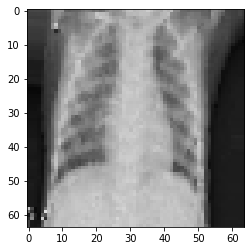

In [18]:
plt.imshow(train_images[0], cmap='gray', vmin=0, vmax=1);

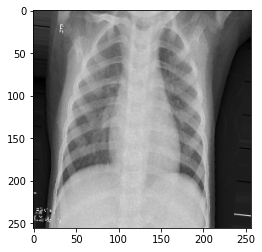

In [21]:
plt.imshow(unaltered_images[0], cmap='gray', vmin=0, vmax=1);

In [26]:
#( number of images, image height, image wideth, color channel(s) )
print(f'train: {train_images.shape}')
print(f'val: {val_images.shape}')
print(f'test: {test_images.shape}')

train: (4173, 64, 64, 1)
val: (1043, 64, 64, 1)
test: (624, 64, 64, 1)


In [29]:
#confirm correct shape for labels
print(train_labels.shape)
print(val_labels.shape)
print(test_labels.shape)

(4173,)
(1043,)
(624,)


We also reshaped our features and labels to be passed into dense layers in our CNN models.

In [32]:
#reshaping features for dense layers
train_reshape = train_images.reshape(train_images.shape[0], -1)
val_reshape = val_images.reshape(val_images.shape[0], -1)
test_reshape = test_images.reshape(test_images.shape[0], -1)

train_y = np.reshape(train_labels, (4173,1))
val_y = np.reshape(val_labels, (1043,1))
test_y = np.reshape(test_labels, (624,1))

print('Reshaped images:')
print(train_reshape.shape)
print(val_reshape.shape)
print(test_reshape.shape)

print('\nReshaped labels:')
print(train_y.shape)
print(val_y.shape)
print(test_y.shape)

Reshaped images:
(4173, 4096)
(1043, 4096)
(624, 4096)

Reshaped labels:
(4173, 1)
(1043, 1)
(624, 1)


We've accomplished the following with our data preparation:
* Transformed image data into tensors
* Performed data augmentation for our training data
* Split 20% of our training data into a validation set
* Prepared a holdout test set for final model evaluation
* Reshaped data into the right shapes for our CNN layers

## Modeling

### Dummy Classifier

We used sklearn's DummyClassifier to establish a baseline for model performance. This DummyClassifier predicts the majority class (pneumonia) for every instance and has an accuracy of 74.3%.

In [33]:
dummy_clf = DummyClassifier()
dummy_clf.fit(train_images, train_labels)
dummy_clf.score(train_images, train_labels)

0.7428708363287803

### CNNs

The three metrics we used in evaluating our models were loss, accuracy, and recall. Our model was designed to provide a second opinion for doctors.

## Results

## Conclusion